In [1]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}

def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

# A High-Level Overview of the Representation Toolbox

In this overview, we will explore different options for representing acoustic signals. This is an important consideration when constructing a machine learning (ML) pipeline, since we want to provide our networks with inputs that are as meaningful as possible. For this project, we'll use a tonal orca call and a transient sperm whale click.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import soundfile as sf
from IPython.display import Audio

from fastai2.vision.all import *

In [3]:
path = untar_data('https://storage.googleapis.com/ml-bioacoustics-datasets/orchive-dataset.tar.gz')

In [4]:
call_path = Path('../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01')
file_path = call_path.ls()[0]

In [5]:
class Labelling(object):
    
    def __init__(self, path):
        self.path=path
        
    def get_path_name(self):
        return str(self.path)
    
    def get_aiff_name(self):
        path_name = self.get_path_name()
        return path_name.split('/')[-1]
    
    def gen_label(self):
        aiff_name = self.get_aiff_name()
        label = aiff_name.split('-')[0] + '-' + aiff_name.split('-')[1]
        return label
    
    def get_matriline(self):
        label = self.gen_label()
        return label.split('-')[0]
    
    def get_call_type(self):
        label = self.gen_label()
        return label.split('-')[1]
        
    
labeller = Labelling(file_path)
print(f'Original Path: {labeller.get_path_name()}')
print(f'File Name: {labeller.get_aiff_name()}')
print(f'Signal Label: {labeller.gen_label()}')
print(f'Matriline: {labeller.get_matriline()}')
print(f'Call Type: {labeller.get_call_type()}')

Original Path: ../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff
File Name: A36-N01-062802-D004-12218.aiff
Signal Label: A36-N01
Matriline: A36
Call Type: N01


Now that we've loaded the orca data, let's see what it sounds like.

In [6]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data_orca, sample_rate_orca = sf.read(path_name)
Audio(data_orca, rate=sample_rate_orca)

Now for the sperm whale clicks:

In [7]:
file = 'data/WatkinsPMacro.wav'
data_sw, sample_rate_sw = sf.read(file)
Audio(data_sw, rate=sample_rate_sw)

Ok great! But for the purposes of this presentation, we'll focus on a single click:

In [8]:
click_sw = data_sw[31000:37500]
Audio(click_sw, rate=sample_rate_sw)

# Time and Frequency Space Representations

Here, we will plot the original signal in both the time and frequency domains. we are employing a mathematical technique called a discrete Fourier transform (DFT) to convert from the time domain to the frequency domain, and we make use of the fast Fourier transform (FFT) algorithm to compute the transform quickly and efficiently.

In [9]:
from scipy.fft import fft

In [10]:
def plot_t_and_f_reps(signal, fs, lw=0.1, fmax=6e3):
    N = len(signal)
    delta_t = 1 / fs
    times = np.arange(0, N) / fs
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(times, signal, linewidth=lw)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Time Domain Representation')
    
    axs[1].plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Frequency Domain Representation')
    axs[1].set_xlim([0, fmax])
    
    plt.show()

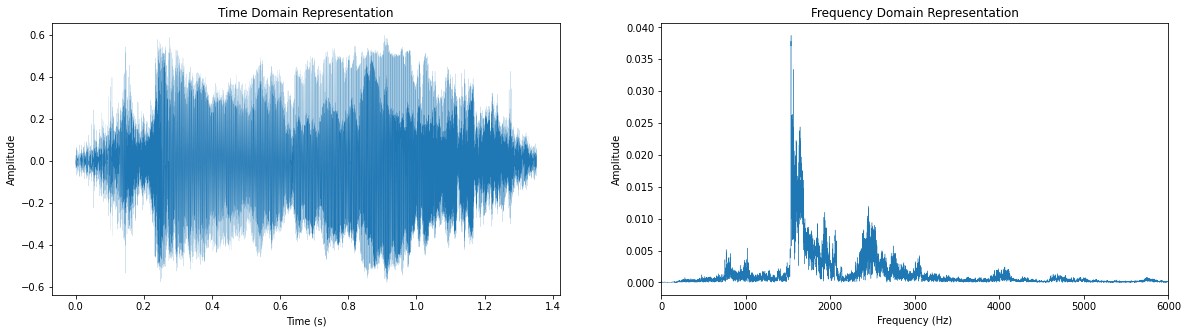

In [11]:
plot_t_and_f_reps(data_orca, sample_rate_orca)

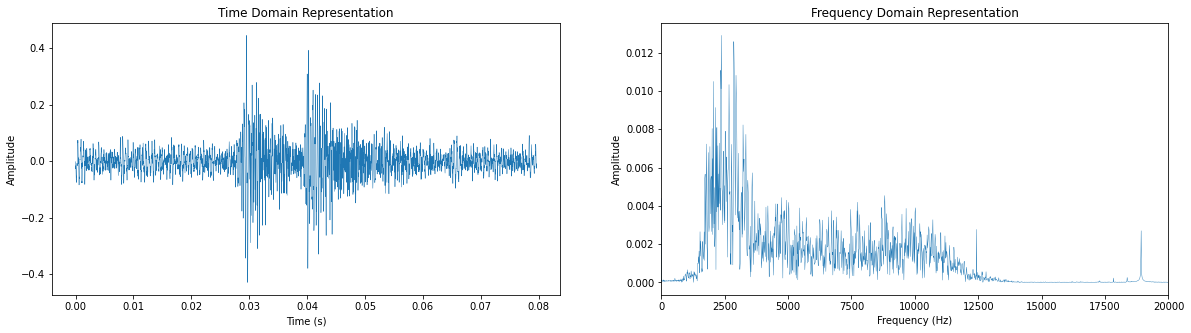

In [12]:
plot_t_and_f_reps(data_sw[31000:37500], sample_rate_sw, lw=0.5, fmax=2e4)

While these raw audio representation can be directly used as inputs, it's often helpful to carry out feature engineering in order to transform to fime-frequency representations.

# Spectrograms

A conventional approach for transforming 1-dimensional acoustic signals into 2-dimensional 'images' is through the construction of a spectrogram. The process of generating a spectrogram requires splitting the signal into overlapping segments and applying the Fourier transform to these windows. This is called the short time Fourier transform (STFT). Let's see what our orca signal looks like.

In [13]:
from scipy.signal import spectrogram

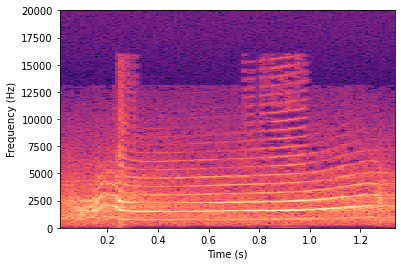

In [14]:
f_bins, t_bins, Sxx = spectrogram(data_orca, fs=sample_rate_orca,
                                 window='hanning', nperseg=1024,
                                 noverlap=1024-512, detrend=False,
                                 scaling='spectrum')
plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 2e4])
plt.show()

However, there are many parameters to consider when constructing spectrograms. To begin unpacking the numerous options, we start by considering the uncertainty principle, which tells us that there is a tradeoff between time resolution and frequency resolution, since we can't simultaneously minimize both. The parameter ``nperseg`` yields insights into these resolutions. 

Using ``nperseg=1024`` with a sample rate of 44.1 kHz leads to a window length (temporal resolution) of 

$$ \frac{1024}{44100} = 0.023 \text{s} $$

and a frequency resolution of 

$$ \frac{44100}{1024} = 43.1 \text{Hz}$$

This tells us that all else equal, increasing ``nperseg`` improves frequency resolution but impairs temporal resolution. This is demonstrated in the following plot.

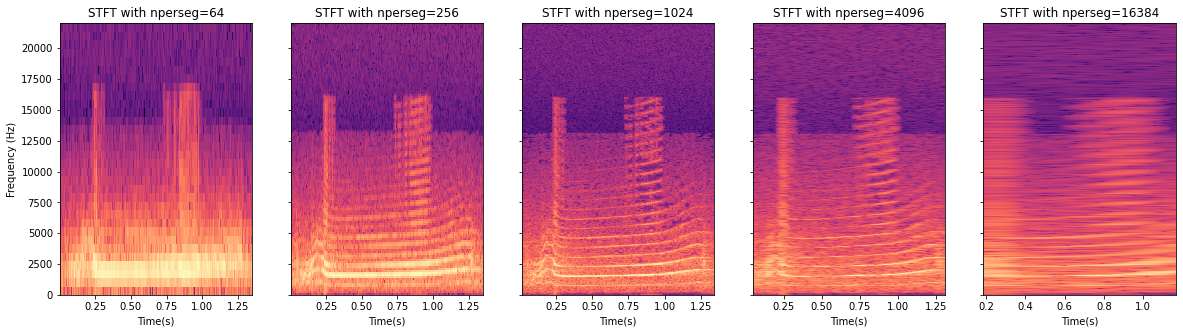

In [15]:
npersegs = [64, 256, 1024, 4096, 16384]
fig, axs = plt.subplots(1, len(npersegs), sharey=True, figsize=(20,5))
axs[0].set_ylabel('Frequency (Hz)')

for i, window_length in enumerate(npersegs):
    f_bins, t_bins, Sxx = spectrogram(data_orca, fs=sample_rate_orca,
                                 window='hanning', nperseg=window_length,
                                 noverlap=window_length-64, detrend=False,
                                 scaling='spectrum')
    axs[i].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    axs[i].set_xlabel('Time(s)')
    axs[i].set_title(f'STFT with nperseg={window_length}')

Why is this of interest? Well, in [Pre-processing spectrogram parameters improve the accuracy of bioacoustic classification using convolutional neural networks](https://www.tandfonline.com/doi/abs/10.1080/09524622.2019.1606734?src=recsys&journalCode=tbio20), the authors found that they could increase classification accuracy from 88.9% to 96.9% simply by optimizing spectrogram parameters.

In order to automate this selection process, we've constructed a goodness metric using principal component analysis.

In [16]:
from scipy import interpolate
from sklearn.decomposition import PCA
from itertools import count

signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

def spec_rep_goodness(x=signal_orca, sr=sr_orca, win='hann', win_length=1024, n_pca=100, th=0.95, vis=True):
    f, t, Sxx = spectrogram(x, fs=sr, window=win, nperseg=win_length,
                            noverlap=win_length//2, detrend=False,
                            scaling='spectrum')
    
    tt, ff = np.meshgrid(t, f)
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(Sxx+1e-100), kind='cubic')
    
    t_interp = np.linspace(t.min(), t.max(), 1000)
    f_interp = np.linspace(f.min(), f.max(), 1000)
    Sxx_interp = interp_fx(t_interp, f_interp)
    
    if vis:
        fog = plt.figure()
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    
    pca = PCA(n_components=n_pca)
    pca.fit(Sxx_interp)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

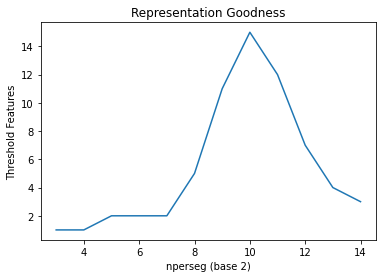

In [17]:
ps = np.arange(3, 15)
th_features = []
for p in ps:
    th_features.append(spec_rep_goodness(win_length=2**p, vis=False))
plt.figure()
plt.plot(ps, th_features)
plt.xlabel('nperseg (base 2)')
plt.ylabel('Threshold Features')
plt.title('Representation Goodness')
plt.show()

While this simple goodness manifold agrees with our visual perception of the representations, it's possible to explore higher dimensional manifolds involving more parameters, and we can analyze the performance on downstream tasks.

## Time-Frequency Reassigned Spectrograms

As we've discussed earlier, the spectrogram-based representation of acoustic signals unfortunately demands a tradeoff between spectral and temporal resolution. The time-frequency reassigned (TFR) spectrogram provides a means to achieve sharper resolutions. Here, we will explore this approach to acoustic signal representation.

Unlike the conventional STFT approach, which yields a blurred representation, the TFR method maps data
to time-frequency coordinates that are nearer to the true region of support of the analyzed signal, yielding a sharper representation of the original signal.

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


output_frame_count 467


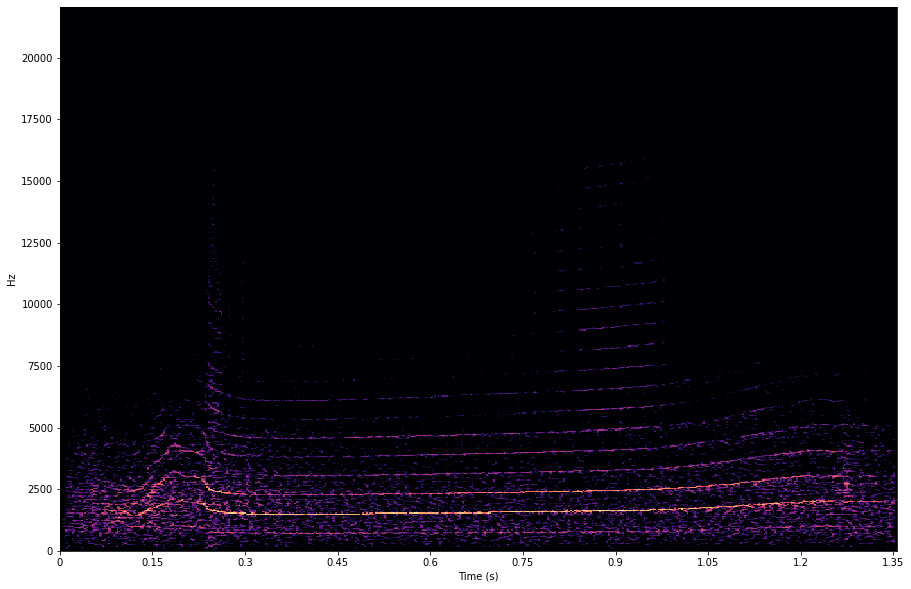

In [18]:
import tfr
import librosa.display
import warnings
warnings.simplefilter('ignore', FutureWarning)

signal_frames = tfr.SignalFrames(path_name, frame_size=1024, hop_size=128)
x_spectrogram = tfr.reassigned_spectrogram(signal_frames)
fig = plt.figure(figsize=(15,10))
librosa.display.specshow(x_spectrogram.T, x_axis="s", y_axis="linear", sr=sr_orca, hop_length=128, cmap='magma')
plt.show()

## Baseline

Here, we'll run an experiment using an open source macaque dataset to test our spectrogram representation:

In [19]:
SR = 24414
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
FMAX = 7500
DB_TH = 1e-4
RES = 128
BATCH_SIZE = 16
BUFFER_SIZE = 6000
LATENT_DIM = 128
EPOCHS = 25
MAX = 1
MIN = 0
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'

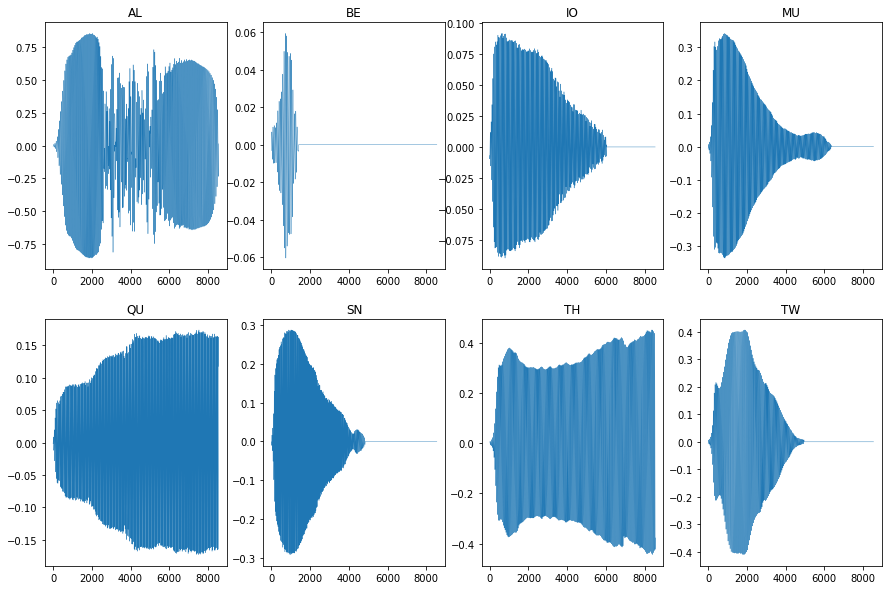

In [20]:
class LoadData(object):
    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [21]:
MEAN_DURATION = mean_dur
WINDOW_WIDTH = MEAN_DURATION

In [22]:
from sklearn.model_selection import train_test_split

X_numpy = np.zeros((len(data_df), MEAN_DURATION), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X_numpy[i, :] = wf
Y=data_df.Category.values

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2995, 8549), (749, 8549), (2995,), (749,))

In [23]:
import tensorflow as tf

class SpecGram(tf.keras.layers.Layer):
    def __init__(self, name='spectrogram', **kwargs):
        super(SpecGram, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.spectrogram_representation(input_)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, sr=SR, nfft=NFFT, hoplength=HOP_LENGTH, win=WINDOW, db_th=DB_TH):
            if hoplength is None:
                hoplength = nfft//16

            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return t_bins,f_bins, spec_db

        def interp_spectrogram(spec, t, f, res=RES, fmax=FMAX):
            if fmax is None:
                fmax = np.max(f)

            interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
            ts_interp = np.linspace(np.min(t), np.max(t), res)
            freqs_interp = np.linspace(np.min(f), fmax, res)
            spec_interp = interp_fx(ts_interp, freqs_interp)
            return spec_interp, freqs_interp, ts_interp

        def generate_representation(waveform, sr=SR, nfft=NFFT, db_th=DB_TH, win=WINDOW, res=RES, fmax=FMAX):
            batch_size= waveform.shape[0]
            reps = np.zeros((batch_size, res, res))
            for n in range(batch_size):
                t, f, Sxx = construct_spectrogram(waveform[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                rep, _, _ = interp_spectrogram(Sxx, t, f, res, fmax)
                reps[n, :, :] = rep
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, RES, RES))

    def get_config(self):
        config = super(SpecGram, self).get_config()
        return config

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))

        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].imshow(reps[n, :, :].numpy(), cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

In [24]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [25]:
class SpecBuilder(tf.keras.Model):

    def __init__(self):
        super(SpecBuilder, self).__init__()
        self.builder = self.build_spec_model()

    def build_spec_model(self):
        spec_inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
        x = SpecGram()(spec_inputs)
        x = MinMaxScaler()(x)
        outputs = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

        spec_model = tf.keras.Model(spec_inputs, outputs, name='spec_builder')
        return spec_model

    def call(self, x):
        return self.builder(x)

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:718: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:878: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)


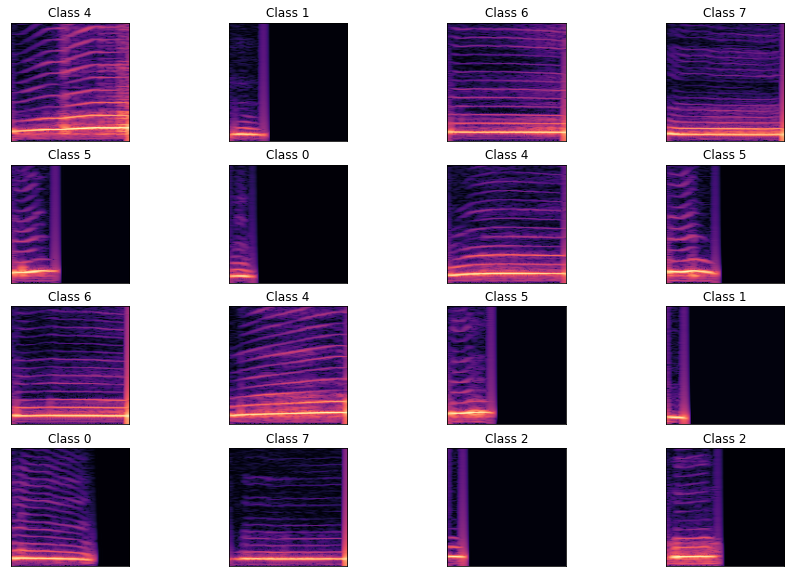

In [26]:
SpecGram().vis_rep(X_train[0:16], Y_train[0:16])

With our data loaded and labeled, we can proceed to train a convolution neural network (CNN) to classify the spectrograms according to the identity of the vocalizing macaque. CNNs work effectively by extracting hierarchical features from the input data, as illustrated in the visualization available [here](https://distill.pub/2017/feature-visualization/).

![title](data/CNN_Feature_Vis.PNG)

In [27]:
def build_baseline_classifier():
    inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
    x = SpecGram()(inputs)
    x = MinMaxScaler()(x)
    x = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='baseline_classifier')
    return classifier

baseline_model = build_baseline_classifier()
baseline_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
baseline_model.summary()

Model: "baseline_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8549)]            0         
_________________________________________________________________
spectrogram (SpecGram)       (None, 128, 128)          0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 128, 128)          0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)

In [28]:
with tf.device('/GPU:0'):
    baseline_model.fit(X_train, Y_train,
                     batch_size=BATCH_SIZE,
                     epochs=10,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/10
  3/169 [..............................] - ETA: 32s - loss: 2.1876 - accuracy: 0.1458

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:718: RuntimeWarning: divide by zero encountered in true_divide
  correction = -np.imag(S_dh / S_h)


169/169 [==============================] - 52s 308ms/step - loss: 0.7311 - accuracy: 0.7540 - val_loss: 0.1508 - val_accuracy: 0.9533
Epoch 2/10
169/169 [==============================] - 52s 306ms/step - loss: 0.2302 - accuracy: 0.9276 - val_loss: 0.1063 - val_accuracy: 0.9600
Epoch 3/10
169/169 [==============================] - 52s 305ms/step - loss: 0.1541 - accuracy: 0.9466 - val_loss: 0.0854 - val_accuracy: 0.9633
Epoch 4/10
169/169 [==============================] - 52s 305ms/step - loss: 0.1256 - accuracy: 0.9625 - val_loss: 0.0776 - val_accuracy: 0.9667
Epoch 5/10
169/169 [==============================] - 51s 302ms/step - loss: 0.1025 - accuracy: 0.9711 - val_loss: 0.0457 - val_accuracy: 0.9700
Epoch 6/10
169/169 [==============================] - 51s 303ms/step - loss: 0.0856 - accuracy: 0.9677 - val_loss: 0.0406 - val_accuracy: 0.9833
Epoch 7/10
169/169 [==============================] - 51s 302ms/step - loss: 0.0617 - accuracy: 0.9811 - val_loss: 0.0387 - val_accuracy: 0.9

In [29]:
baseline_model.evaluate(X_test, Y_test)

24/24 [==============================] - 12s 482ms/step - loss: 0.0752 - accuracy: 0.9880


[0.07521103322505951, 0.9879840016365051]

# Wavelet Scattering Transforms

 This transform is constructed as a convolutional network whose filters are fixed to be wavelet and lowpass averaging filters coupled with modulus nonlinearities, and the resultant transform is invariant to translations and diffeomorphisms, which makes it suitable for CNN-based audio processing.

## Motivating the Transform

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from fastai2.vision.all import *

import librosa
from librosa.display import specshow
import soundfile as sf
import scipy.signal
from kymatio.numpy import Scattering1D
from sklearn.model_selection import train_test_split

import tensorflow as tf

import pathlib
from IPython.display import Audio
import functools
import tqdm
import time
from IPython import display

Naively, a spectrogram looks like an image, so it seems to make since to use tools designed for image processing, such as CNNs. However, a spectrogram is fundamentally different from an image, so many of the advantages of CNNs do not apply when working with spectrogram datasets.

For instance, CNNs are purposefully designed to capitalize on invariances that characterize image data. These invariances include (1) rotation, (2) scale, (3) translation, and (4) reflection invariance. What does this mean in practice? Well, let's consider the following image.

In [31]:
def load_image(img_path):
    from PIL import Image
    img = Image.open(img_path)
    return img

def show_image(img):
    plt.figure(figsize=(6,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

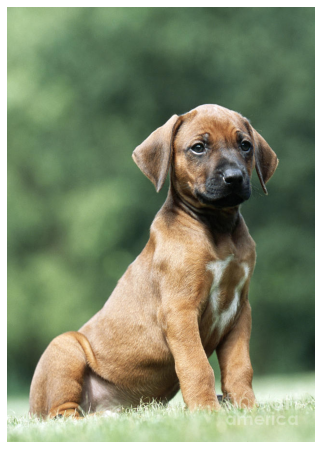

In [32]:
I = load_image('08_Extras/rhodesian_puppy.jpg')
show_image(I)

What happens if we transform the image?

In [33]:
def rotate_image(img, D):
    import scipy.ndimage
    img_D = scipy.ndimage.rotate(img, D, reshape=False)
    return img_D

def zoom_image(img, Nx0, Nx1):
    import scipy.ndimage
    Nx = (Nx0, Nx1, 1)
    img_Nx = scipy.ndimage.zoom(img, Nx)
    dim0 = np.array(img).shape[0]
    dim1 = np.array(img).shape[1]
    cut0 = dim0 - int(dim0 / Nx0)
    cut1 = dim1 - int(dim1 / Nx1)
    img_Nx = img_Nx[cut0:cut0+dim0, cut1:cut1+dim1, :]
    return img_Nx

def shift_image(img, shift_X, shift_Y):
    import scipy.ndimage
    shift = (shift_Y, shift_X, 0)
    img_shift = scipy.ndimage.shift(img, shift)
    return img_shift

def reflect_image(img, axis='X'):
    from PIL import ImageOps
    if axis == 'X':
        img_ref = ImageOps.mirror(img)
    else:
        img_ref = ImageOps.flip(img)
    return img_ref

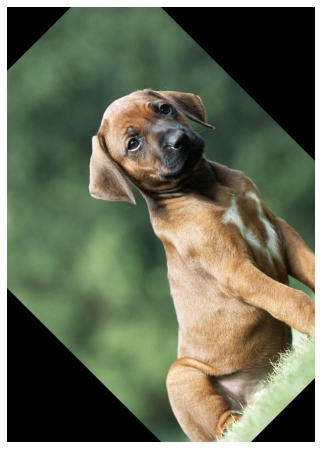

In [34]:
I_45 = rotate_image(I, 45)
show_image(I_45)

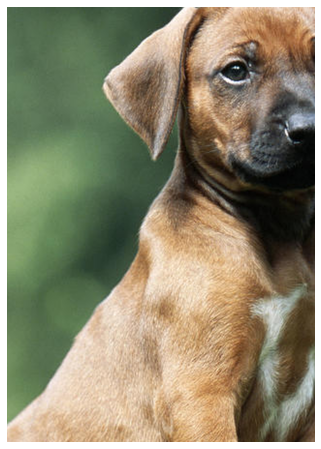

In [35]:
I_2x = zoom_image(I, 2,2)
show_image(I_2x)

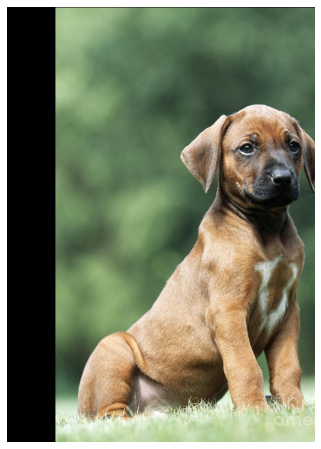

In [36]:
img_100_1 = shift_image(I, 100, 1)
show_image(img_100_1)

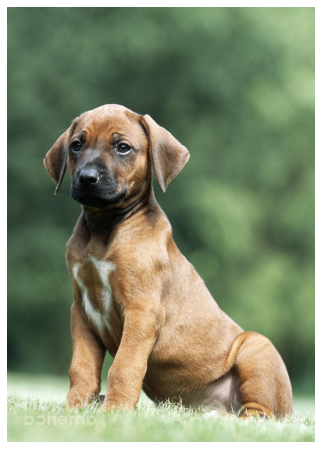

In [37]:
img_mirror = reflect_image(I, 'X')
show_image(img_mirror)

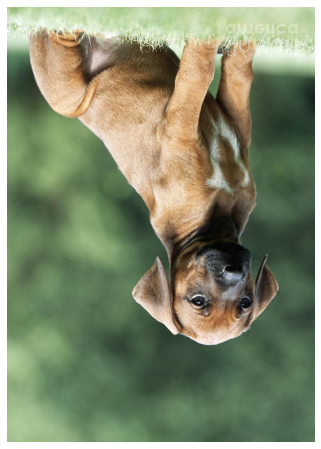

In [38]:
img_flip= reflect_image(I, 'Y')
show_image(img_flip)

We are clearly able to see the puppy regardless of the transformation. This is because image datasets exhibit invariance when performing a number of transformations. CNNs make use of this invariance to carry out classification tasks with a high degree of robustness. This is also why it is possible to use simple transformations to perform data augmentation with image data.

However, these fundamental invariances simply do not apply to audio spectrogram 'image' datasets, primarily due to the inherent meaning of the axes. The x-axis has temporal significance, and the y-axis has spectral significance, so some of the above transformations are not necessarily defined operations when dealing with acoustic data. What does this mean? Let's consider a chirp.

In [39]:
chirp_low_high = librosa.chirp(440, 5440, sr=22050, duration=4)

In [40]:
def generate_spectrogram(signal, sr=22050, low_lim=0, high_lim=22050//2):
    S = librosa.stft(signal)
    return S

def draw_spectrogram(S, title, sr=22050, low_lim=0, high_lim=22050//2):
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(D, y_axis='linear', fmax=sr//2, x_axis='time')
    plt.title(title)
    plt.ylim([low_lim, high_lim])
    plt.colorbar()
    
def invert_spectrogram(S):
    A = librosa.istft(S)
    return A

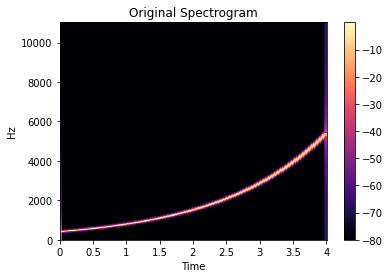

In [41]:
signal = chirp_low_high
S = generate_spectrogram(signal)
draw_spectrogram(S, 'Original Spectrogram')
A = invert_spectrogram(S)
display.Audio(A, rate=22050)

In [42]:
def rotate_spectrogram(S):
    S_90 = np.rot90(S)
    return S_90

def zoom_spectrogram(S, Nx0, Nx1):
    import scipy.ndimage
    Nx = (Nx0, Nx1)
    S_Nx = scipy.ndimage.zoom(np.real(S), Nx) + 1j*scipy.ndimage.zoom(np.imag(S), Nx)
    dim0 = S.shape[0]
    dim1 = S.shape[1]
    cut0 = dim0 - int(dim0 / Nx0)
    cut1 = dim1 - int(dim1 / Nx1)
    S_Nx = S_Nx[cut0:cut0+dim0, cut1:cut1+dim1]
    return S_Nx

def shift_spectrogram(S, shift_X, shift_Y):
    import scipy.ndimage
    shift = (shift_Y, shift_X)
    S_XY = scipy.ndimage.shift(np.real(S), shift) + 1j*scipy.ndimage.shift(np.imag(S), shift)
    return S_XY

def reflect_spectrogram(S, axis='X'):
    if axis == 'X':
        S_ref = np.fliplr(S)
    else:
        S_ref = np.flipud(S)
    return S_ref

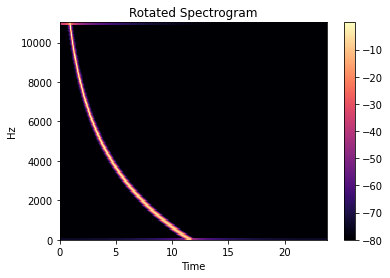

In [43]:
S_90 = rotate_spectrogram(S)
draw_spectrogram(S_90, 'Rotated Spectrogram')
A_90 = invert_spectrogram(S_90)
display.Audio(A_90, rate=22050)

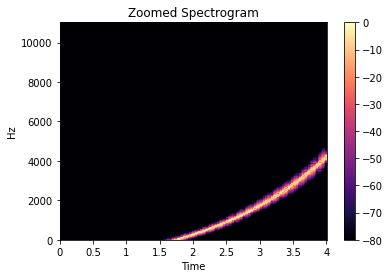

In [44]:
S_12x = zoom_spectrogram(S, 1.2, 1.2)
draw_spectrogram(S_12x, 'Zoomed Spectrogram')
A_12x = invert_spectrogram(S_12x)
display.Audio(A_12x, rate=22050)

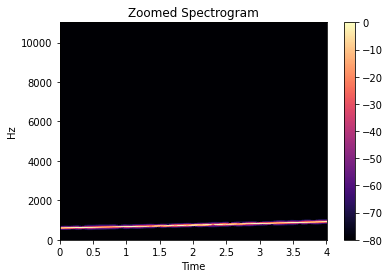

In [45]:
S_1x_6x = zoom_spectrogram(S, 1, 6)
draw_spectrogram(S_1x_6x, 'Zoomed Spectrogram')
A_1x_6x = invert_spectrogram(S_1x_6x)
display.Audio(A_1x_6x, rate=22050)

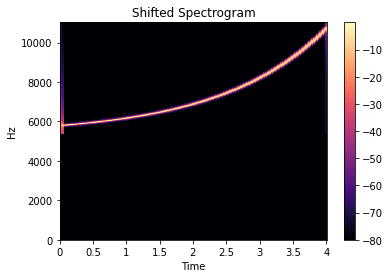

In [46]:
S_1_500 = shift_spectrogram(S, 1, 500)
draw_spectrogram(S_1_500, 'Shifted Spectrogram')
A_1_500 = invert_spectrogram(S_1_500)
display.Audio(A_1_500, rate=22050)

In [47]:
wf, sr = librosa.load('08_Extras/emordnilap.m4a', sr=None)
display.Audio(wf, rate=sr)

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


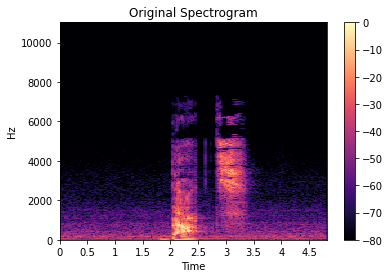

In [48]:
S = generate_spectrogram(wf)
draw_spectrogram(S, 'Original Spectrogram')
A = invert_spectrogram(S)
display.Audio(A, rate=sr)

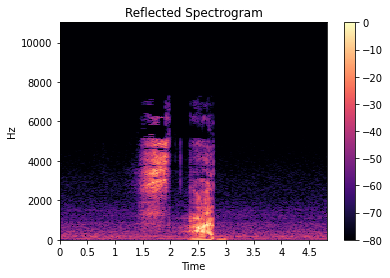

In [49]:
S_mirror = reflect_spectrogram(S, 'X')
draw_spectrogram(S_mirror, 'Reflected Spectrogram')
A_mirror = invert_spectrogram(S_mirror)
display.Audio(A_mirror, rate=sr)

After having established the need for an invariant transform, we'll take a look at a practical implementation of the scattering wavelet transform using the macaque coo call classification dataset.

In [50]:
class Normalizer(tf.keras.layers.Layer):
    
    def __init__(self, name='normalizer', **kwargs):
        super(Normalizer, self).__init__(name=name, **kwargs)
        
    def call(self, input_):
        return self.normalize(input_)
        
    @tf.function
    def normalize(self, x):
        batch, samples = x.shape
        _max = tf.math.reduce_max(tf.abs(x), axis=1, keepdims=True, name=None)
        x_norm = x / _max
        return x_norm
         
normalizer = Normalizer()

In [51]:
X_train_norm, X_test_norm = Normalizer()(X_train).numpy(), Normalizer()(X_test).numpy()

Now that we have our normalized input data, we can proceed to carry out a 1D scattering transform. We need to specify four parameters: (1) T is the number of elements in the time series; (2) J (or 2^J) represents the averaging, or maximum, scale, which is essentially the lowest frequencies to be resolved; (3) Q denotes the number of wavelets per octave; and (4) log_eps is an additive constant to prevent the logarithm from blowing up.

In [52]:
T = 8549
J = 6
Q = 16
log_eps = 1e-6

In [53]:
scattering = Scattering1D(J, T, Q)

In [54]:
Sx_train = np.zeros((X_train.shape[0],221,133), dtype='float32')
import tqdm
for i in tqdm.tqdm(range(X_train.shape[0])):
    Sx = scattering(X_train_norm[i]).astype('float32')
    Sx = Sx[1:, :]
    Sx = np.log10(np.abs(Sx) + log_eps)
    Sx_train[i] = Sx

100%|██████████| 2995/2995 [05:32<00:00,  9.01it/s]


In [55]:
Sx_test = np.zeros((X_test.shape[0],221,133), dtype='float32')
import tqdm
for i in tqdm.tqdm(range(X_test.shape[0])):
    Sx = scattering(X_test_norm[i]).astype('float32')
    Sx = Sx[1:, :]
    Sx = np.log10(np.abs(Sx) + log_eps)
    Sx_test[i] = Sx

100%|██████████| 749/749 [01:23<00:00,  9.02it/s]


In [56]:
Sx_train1 = Sx_train[:, 0:63, :]
Sx_train2 = Sx_train[:, 63:, :]
Sx_train1.shape,Sx_train2.shape

((2995, 63, 133), (2995, 158, 133))

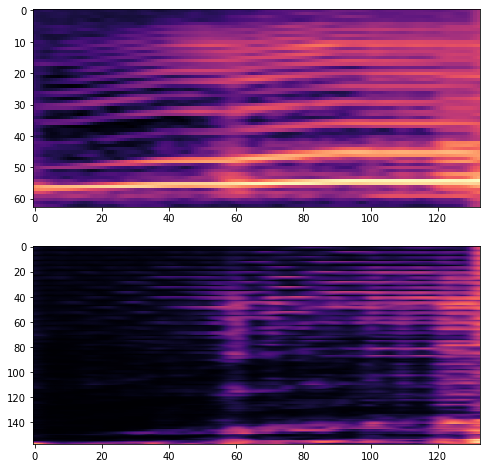

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(Sx_train1[0], aspect='auto', cmap='magma')
plt.subplot(2, 1, 2)
plt.imshow(Sx_train2[0], aspect='auto', cmap='magma')

In [58]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [59]:
def build_dual_cnn():
    inputs1 = tf.keras.Input(shape=(63,133))
    x1 = MinMaxScaler(name='minmax1')(inputs1)
    x1 = tf.keras.layers.Reshape((63,133, 1), input_shape=(63,133))(x1)
    x1 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x1)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = tf.keras.layers.Dropout(0.25)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    
    inputs2 = tf.keras.Input(shape=(158,133))
    x2 = MinMaxScaler(name='minmax2')(inputs2)
    x2 = tf.keras.layers.Reshape((158,133, 1), input_shape=(158,133))(x2)
    x2 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = tf.keras.layers.Dropout(0.25)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.Dropout(0.5)(x2)
    
    x = tf.keras.layers.Concatenate()([x1, x2])
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    
    classifier = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name='dual_classifier')
    return classifier

dual_model = build_dual_cnn()
dual_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dual_model.summary()

Model: "dual_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 158, 133)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 63, 133)]    0                                            
__________________________________________________________________________________________________
minmax2 (MinMaxScaler)          (None, 158, 133)     0           input_3[0][0]                    
__________________________________________________________________________________________________
minmax1 (MinMaxScaler)          (None, 63, 133)      0           input_2[0][0]                    
____________________________________________________________________________________

In [60]:
with tf.device('GPU:0'):
    dual_model.fit([Sx_train1, Sx_train2], Y_train,
              epochs=20,
              batch_size=128,
              validation_split=0.1,
              verbose=1)

Epoch 1/20
22/22 [==============================] - 6s 290ms/step - loss: 0.8192 - accuracy: 0.7239 - val_loss: 0.2010 - val_accuracy: 0.9433
Epoch 2/20
22/22 [==============================] - 5s 249ms/step - loss: 0.1972 - accuracy: 0.9417 - val_loss: 0.1191 - val_accuracy: 0.9567
Epoch 3/20
22/22 [==============================] - 5s 248ms/step - loss: 0.1120 - accuracy: 0.9607 - val_loss: 0.1234 - val_accuracy: 0.9600
Epoch 4/20
22/22 [==============================] - 5s 248ms/step - loss: 0.0908 - accuracy: 0.9733 - val_loss: 0.0727 - val_accuracy: 0.9700
Epoch 5/20
22/22 [==============================] - 5s 248ms/step - loss: 0.0544 - accuracy: 0.9833 - val_loss: 0.0446 - val_accuracy: 0.9867
Epoch 6/20
22/22 [==============================] - 5s 248ms/step - loss: 0.0555 - accuracy: 0.9844 - val_loss: 0.0285 - val_accuracy: 0.9900
Epoch 7/20
22/22 [==============================] - 5s 249ms/step - loss: 0.0349 - accuracy: 0.9900 - val_loss: 0.0125 - val_accuracy: 0.9967
Epoch 

In [61]:
Sx_test1 = Sx_test[:, 0:63, :]
Sx_test2 = Sx_test[:, 63:, :]
Sx_test1.shape,Sx_test2.shape

((749, 63, 133), (749, 158, 133))

In [62]:
dual_model.evaluate([Sx_test1, Sx_test2], Y_test)

24/24 [==============================] - 1s 34ms/step - loss: 0.0429 - accuracy: 0.9947


[0.042901329696178436, 0.9946595430374146]

## Deep-Learned Approach

Alternatively, we can explore deep-learned representations. For instance, we can train a generative model such as a gradient origin network (GON), generative adversarial interpolative autoencoder (GAIA), generative adversarial network (GAN), or variational autoencoder (VAE), among other possible model types. In doing so, we can investigate the latent space representation, which oftentimes exhibits denser clustering (which we quantitatively and qualitatively analyze in the toolbox).

In [63]:
from IPython.display import Video

Video('07_Animations/MacaqueGAIA.mp4')

In [64]:
Video('07_Animations/MacaqueLatentSpaceTSNE.mp4')

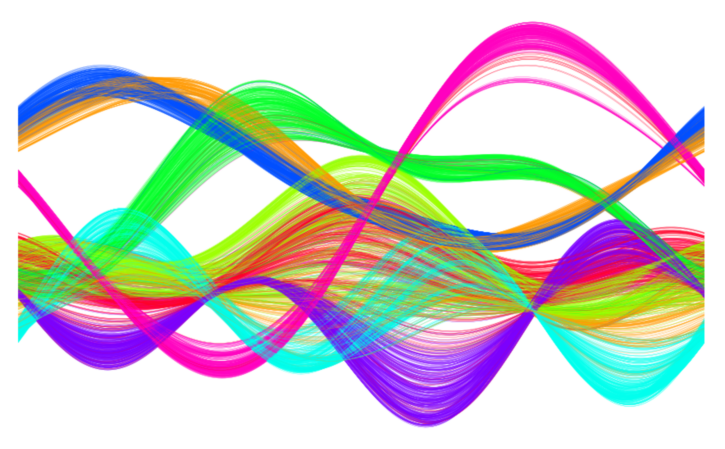

In [65]:
import matplotlib.pyplot as plt
def load_image(img_path):
    from PIL import Image
    img = Image.open(img_path)
    return img

def show_image(img, size=(18,8)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
I = load_image('07_GON/GON_Representation.PNG')
show_image(I)

Also, deep-learned representations enable us to carry out novel methods for noise reduction. For instance, the following image provides an illustration of a self-supervised VAE-based noise reduction algorithm.

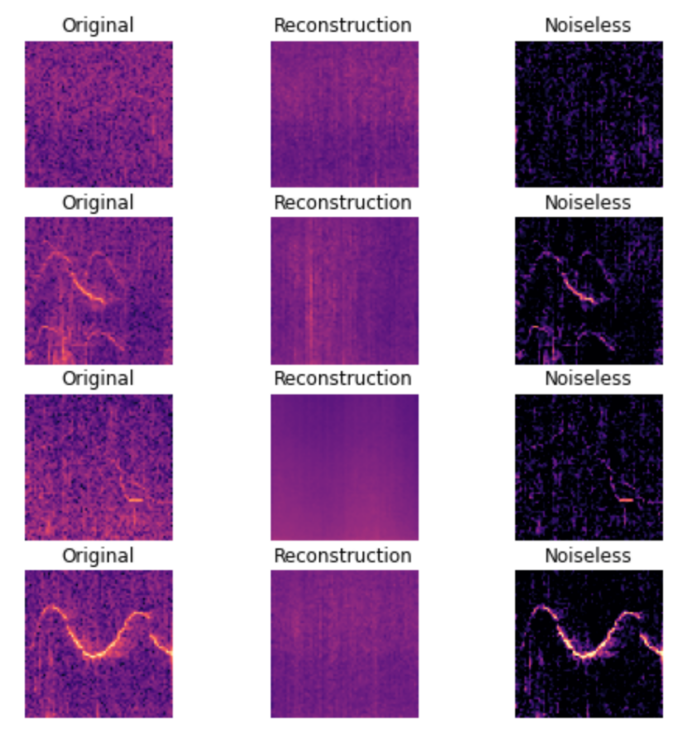

In [66]:
I = load_image('../Dolphin_Noise_Reduction.PNG')
show_image(I, size=(12, 14))

# Other Representations

There are a number of alternatives that we explore in the representation toolkit. One of these is the Hilbert Huang transform, which has often been used for transient signals. It might also be applicable when considering the cocktail party problem, as described in [Single Channel speech separation based on empirical mode decomposition and Hilbert Transform](https://ieeexplore.ieee.org/document/7954778). Others include continuous wavelet transforms as well as spectral hyperresolution representations.